## what this file is for ##
it was previously the file to create datasets out of my h5 file AND train a network on it.
it is now only here to create npy datasets out of h5 files. all code below that is pure playing.
the h5 file contains mcprimary and inicedstpulses.

In [1]:
import os
import sys
import numpy as np
#os.environ['THEANO_FLAGS'] = "device=gpu, floatX = float32"  
#os.environ["PATH"] += os.pathsep + '/usr/local/cuda/bin/nvcc'
import theano
# theano.config.device = 'gpu'
# theano.config.floatX = 'float32'
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
import itertools
import tables

Using Theano backend.
/home/jkager/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#find this file under cobalt: /data/user/jkager/files/inicedstpulses_nugen11069_first50i3files.h5
pulses_file = "/data/user/jkager/files/inicedstpulses_nugen11069_first100i3files.h5"

take care with that dataset: entry (1106900050, 1612) appeares to be available twice in MCPrimary table... delete it manually.

In [3]:
def load_geo_data(geo_file):
    #return the contents of the geo file as
    #dictionary mapping (omkey[0],omkey[1]) -> (posx,posy,poz)
    import csv
    ret = {}
    with open(geo_file, 'r') as f:
        reader = csv.reader(f)
        for line in reader:
            key = tuple(map(int, line[0:2]))
            val = tuple(map(float, line[2:5]))
            ret[key] = val
    return ret

In [13]:
def produce_raw_xlist(geo=None, std_val = 0.0):
    """
    returns a two tuple:
    1) a np array of lenght #DOMS filled with std_val. copy this for every dataset later on
    2) a dictionary mapping (string, om) to an index (something like $index = (string-1)*60+(om-1)$)
    
    geo is the object created by load_geo_data. 
    if no geo specified use standard values: string in [1,86], om in [1,60]
    """
    if geo:
        dom_to_index = {}
        raw_xlist = np.full((len(geo)), std_val, dtype=np.float32) #this will also be the value used for non hit DOM's
        for i, dom in enumerate(geo.keys()):
            dom_to_index[dom] = i
        return raw_xlist, dom_to_index
    else: #no geo file specified, use standard values: string in [1,86], om in [1,60]
        dom_to_index = {}
        for i, (string, om) in enumerate(itertools.product(range(1,87), range(1,61))):
            dom_to_index[(string, om)] = i
        raw_xlist = np.full((86*60), std_val, dtype=np.float32)
        return raw_xlist, dom_to_index

In [69]:
def load_pulses_data(pulses_file, geo_file=None, using="charge"):
    #returns data from dstpulses. Returns only the first puls from each dom in the list.
    #splits per frames
    """Return a tuple containing ``(data,  labels)``.
    
    In particular, ``data`` is a list containing a dozen thousand
    lists ``[chargedom1,chargedom2,...]``.  the index of the dom is simply a walkthrough through 
    every (string, om)-pair
    
    ``labels`` is the
    corresponding information about being a north or south-coming particle,
    i.e., 0 for above (from south, down) and 1 for below (from north, up). this is chosen on the
    zenith angle of MCTree's most energetic primary (1 for > 90deg or 0 for < 90deg). it is made categorical:
    [[0,1],[0,1],[1,0],...] for [up, up, down, ...] or equally [1,1,0,...]

    For DOMs that include multiple pulses, -the earliest time is used for simplification- sum of charge is used.
    """

    def get_pos(dom_to_index, string, om):
        if (string, om) not in dom_to_index:
            return -1
        return dom_to_index[(string, om)]

    def normalize_time(time_list):
        maxtime, mintime = 0, float("inf")
        for t in time_list:
            if t == np.inf:
                continue
            maxtime = max(maxtime, t)
            mintime = min(mintime, t)
        if mintime == np.inf:
            return
        timespan = maxtime - mintime
        time_list -= mintime
        if timespan > 0.0:
            time_list /= timespan
    def normalize_charge(charge_list):
        maxcharge, mincharge = 0, float("inf")
        for c in charge_list:
            maxcharge = max(maxcharge, c)
            mincharge = min(mincharge, c)
        span = maxcharge - mincharge
        charge_list -= mincharge
        charge_list /= span

    raw_xlist, dom_to_index = None, None
    if using=="charge":
        raw_xlist, dom_to_index = produce_raw_xlist(std_val=0.0)
    elif using == "time":
        raw_xlist, dom_to_index = produce_raw_xlist(std_val=np.inf)

    h5file = tables.open_file(pulses_file)
    dst = h5file.root.InIceDSTPulses.cols
    prim = h5file.root.MCPrimary.cols

    data = []   #total charge (summed over pulses) per dom and per frame. 2d numpy array
    labels = [] #up or down, categorical [[0,1],[0,1],[1,0],...]. 2d numpy array
    prev_frame = (dst.Run[0],dst.Event[0])
    prev_dom = (-1,-1)
    x_list = np.copy(raw_xlist)
    count = 0
    x_i = 0

    for zenith in prim.zenith:
        labels.append(1 if zenith > 1.5707963268 else 0) #1==down, 0==up
    labels = np_utils.to_categorical(labels)

    total_rows = len(dst.Run)
    i=0
    if using == "charge":
        for run, event, string, om, time, charge in zip(dst.Run, dst.Event, dst.string, dst.om, \
                                                        dst.time, dst.charge):
            if (run, event) != prev_frame: #next frame is coming, so push this out as charges list
                normalize_charge(x_list)
                data.append(x_list)
                x_list = np.copy(raw_xlist)
                count += 1
                prev_frame = (run,event)

            if (string, om) == prev_dom: #already saw that dom (it has multiple pulses)
                x_list[dom_index] += charge
            else: #pulse for new dom
                if om <= 60: #filter out those om=61,62,63,64 (i.e. icetop). we're not interested in them
                    dom_index = get_pos(dom_to_index, string, om)
                    if dom_index == -1: #just to make sure
                        continue
                    x_list[dom_index] = charge
                    prev_dom = (string, om)

            # show an update every 1,000 images
            if i > 0 and i % 10**6 == 0:
                print("[INFO] processed {}/{}".format(i, total_rows))
            i += 1

        #add the last frame manually
        normalize_charge(x_list)
        data.append(x_list)
    elif using == "time":
        for run, event, string, om, time, charge in zip(dst.Run, dst.Event, dst.string, dst.om, \
                                                        dst.time, dst.charge):
            if (run, event) != prev_frame: #next frame is coming, so push this out as charges list
                normalize_time(x_list)
                data.append(x_list)
                x_list = np.copy(raw_xlist)
                count += 1
                prev_frame = (run,event)

            if (string, om) == prev_dom: #already saw that dom (it has multiple pulses)
                pass
            else: #pulse for new dom
                if om <= 60: #filter out those om=61,62,63,64 (i.e. icetop). we're not interested in them
                    dom_index = get_pos(dom_to_index, string, om)
                    if dom_index == -1:
                        continue
                    x_list[dom_index] = time
                    prev_dom = (string, om)

            # show an update every 1,000 images
            if i > 0 and i % 10**6 == 0:
                print("[INFO] processed {}/{}".format(i, total_rows))
            i += 1

        #add the last frame manually
        normalize_time(x_list)
        data.append(x_list)

    return (np.array(data), labels)

In [70]:
data, labels = load_pulses_data(pulses_file,using="time")

[INFO] processed 1000000/43287699
[INFO] processed 2000000/43287699
[INFO] processed 3000000/43287699
[INFO] processed 4000000/43287699
[INFO] processed 5000000/43287699
[INFO] processed 6000000/43287699
[INFO] processed 7000000/43287699
[INFO] processed 8000000/43287699
[INFO] processed 9000000/43287699
[INFO] processed 10000000/43287699
[INFO] processed 11000000/43287699
[INFO] processed 12000000/43287699
[INFO] processed 13000000/43287699
[INFO] processed 14000000/43287699
[INFO] processed 15000000/43287699
[INFO] processed 16000000/43287699
[INFO] processed 17000000/43287699
[INFO] processed 18000000/43287699
[INFO] processed 19000000/43287699
[INFO] processed 20000000/43287699
[INFO] processed 21000000/43287699
[INFO] processed 22000000/43287699
[INFO] processed 23000000/43287699
[INFO] processed 24000000/43287699
[INFO] processed 25000000/43287699
[INFO] processed 26000000/43287699
[INFO] processed 27000000/43287699
[INFO] processed 28000000/43287699
[INFO] processed 29000000/432

In [29]:
h5=tables.open_file(pulses_file)
mcp=h5.root.MCPrimary.cols
index_to_remove = -1
for i, (run,event) in enumerate(zip(mcp.Run, mcp.Event)):
    if (run, event) == (1106900050, 1612):
        index_to_remove = i
        break
if len(labels) > len(data): #just to be sure...
    labels = np.delete(labels, index_to_remove, 0)

NameError: name 'labels' is not defined

In [31]:
np.save("updownclassification_using_keras_timedata.npy", data)
np.save("updownclassification_using_keras_labels.npy", labels)

In [27]:
data =   np.load("updownclassification_using_keras_chargedata.npy")
labels = np.load("updownclassification_using_keras_labels.npy")

#filter data. exclude 60deg < zenith < 120deg#

In [4]:
h5=tables.open_file(pulses_file)
mcp=h5.root.MCPrimary.cols
data =   np.load("updownclassification_using_keras_chargedata.npy")
labels = np.load("updownclassification_using_keras_labels.npy")

In [22]:
np.array([0,1])[labels.argmax(1)]

array([0, 1, 0, ..., 0, 0, 0])

In [24]:
labels

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       ..., 
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [5]:
data_filtered = []
labels_filtered = []
included_zeniths = []
for i, entry in enumerate(h5.root.MCPrimary.where("((Run != 1106900050) | (Event != 1612) | (SubEvent != 1))")):
    if entry['zenith'] > 7*np.pi/12 or \
       entry['zenith'] < 5*np.pi/12:
        data_filtered.append(data[i])
        labels_filtered.append(labels[i])
        included_zeniths.append(entry['zenith'])
  # if not np.logical_and(*(here==there)):
  #     print i, here, there
data_filtered = np.array(data_filtered)
labels_filtered = np.array(labels_filtered)
included_zeniths = np.array(included_zeniths)

In [6]:
np.save("updownclassification_using_keras_timedata_filtered.npy", data_filtered)
np.save("updownclassification_using_keras_labels_filtered.npy", labels_filtered)

filtering done
-

In [29]:
(trainData, testData, trainLabels, testLabels) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [30]:
model = Sequential()
model.add(Dense(1024, input_dim=5160, kernel_initializer="uniform",
	activation="relu"))
model.add(Dense(512, kernel_initializer="uniform", activation="relu"))
model.add(Dense(2))
model.add(Activation("softmax"))

In [31]:
#train the model
import time
start=time.time()
sgd = SGD(lr=0.01)
model.compile(loss="binary_crossentropy", optimizer=sgd,
	metrics=["accuracy"])
model.fit(trainData, trainLabels, epochs=20, batch_size=128)
print "time to fit:",time.time()-start

Epoch 1/20
7875/7875 [==============================] - 6s - loss: 0.6921 - acc: 0.5195     
Epoch 2/20
7875/7875 [==============================] - 6s - loss: 0.6893 - acc: 0.5464     
Epoch 3/20
7875/7875 [==============================] - 6s - loss: 0.6883 - acc: 0.5470     
Epoch 4/20
7875/7875 [==============================] - 6s - loss: 0.6877 - acc: 0.5472     
Epoch 5/20
7875/7875 [==============================] - 6s - loss: 0.6872 - acc: 0.5476     
Epoch 6/20
7875/7875 [==============================] - 6s - loss: 0.6868 - acc: 0.5473     
Epoch 7/20
7875/7875 [==============================] - 6s - loss: 0.6864 - acc: 0.5484     
Epoch 8/20
7875/7875 [==============================] - 6s - loss: 0.6859 - acc: 0.5497     
Epoch 9/20
7875/7875 [==============================] - 6s - loss: 0.6855 - acc: 0.5510     
Epoch 10/20
7875/7875 [==============================] - 6s - loss: 0.6851 - acc: 0.5523     
Epoch 11/20
7875/7875 [==============================] - 6s - loss: 0

In [36]:
# show the accuracy on the testing set
print("[INFO] evaluating on testing set...")
(loss, accuracy) = model.evaluate(testData, testLabels,
	batch_size=128, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,
	accuracy * 100))

[INFO] evaluating on testing set...
2560/2626 [============================>.] - ETA: 0s[INFO] loss=0.6839, accuracy: 55.8644%


In [34]:
model.predict(testData[:5])

array([[ 0.46050641,  0.53949362],
       [ 0.44714925,  0.55285072],
       [ 0.4380317 ,  0.56196827],
       [ 0.46625364,  0.53374636],
       [ 0.46789631,  0.53210372]], dtype=float32)

# results #
run locally on macbook:

feedforward neural net 5160-1024-512-2, relu activations. trained on 75% of 10501 datasets. tested on 25%.

Epoch 50/50
7875/7875 [==============================] - 3s - loss: 0.6672 - acc: 0.6000 

[INFO] evaluating on testing set...
2432/2626 [==========================>...] - ETA: 0s[INFO] loss=0.6787, accuracy: 56.5499%

# look at the input data #
which angles do we have?

In [4]:
import tables
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
h5=tables.open_file("/data/user/jkager/files/inicedstpulses_nugen11069_0_last50i3files.h5")

In [11]:
zeniths = np.array(h5.root.MCPrimary.cols.zenith) * 180 / np.pi

In [21]:
zeniths

array([  13.50372123,  123.51217644,   81.25132564, ...,   89.36358153,
         53.36052213,   89.3553739 ])

In [7]:
hist = np.histogram(zeniths,bins=18)

In [23]:
zip(*hist)

[(138, 1.2684182400768134),
 (297, 11.161891870863837),
 (350, 21.055365501650858),
 (394, 30.948839132437882),
 (460, 40.842312763224903),
 (602, 50.735786394011924),
 (687, 60.629260024798953),
 (847, 70.522733655585967),
 (1034, 80.416207286372995),
 (977, 90.309680917160023),
 (922, 100.20315454794704),
 (881, 110.09662817873406),
 (805, 119.99010180952109),
 (700, 129.88357544030811),
 (576, 139.77704907109512),
 (447, 149.67052270188216),
 (292, 159.56399633266918),
 (93, 169.45746996345619)]

In [50]:
sum(hist[0][12:]+hist[0][0:6])

5154

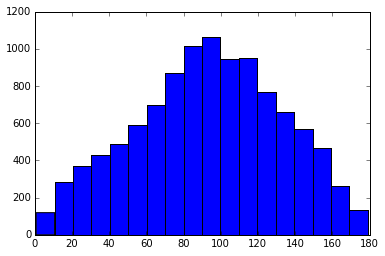

In [12]:
plt.hist(zeniths, 18)
plt.show()